In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.tools.visualization import plot_histogram
import pandas as pd
from fractions import Fraction


In [2]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

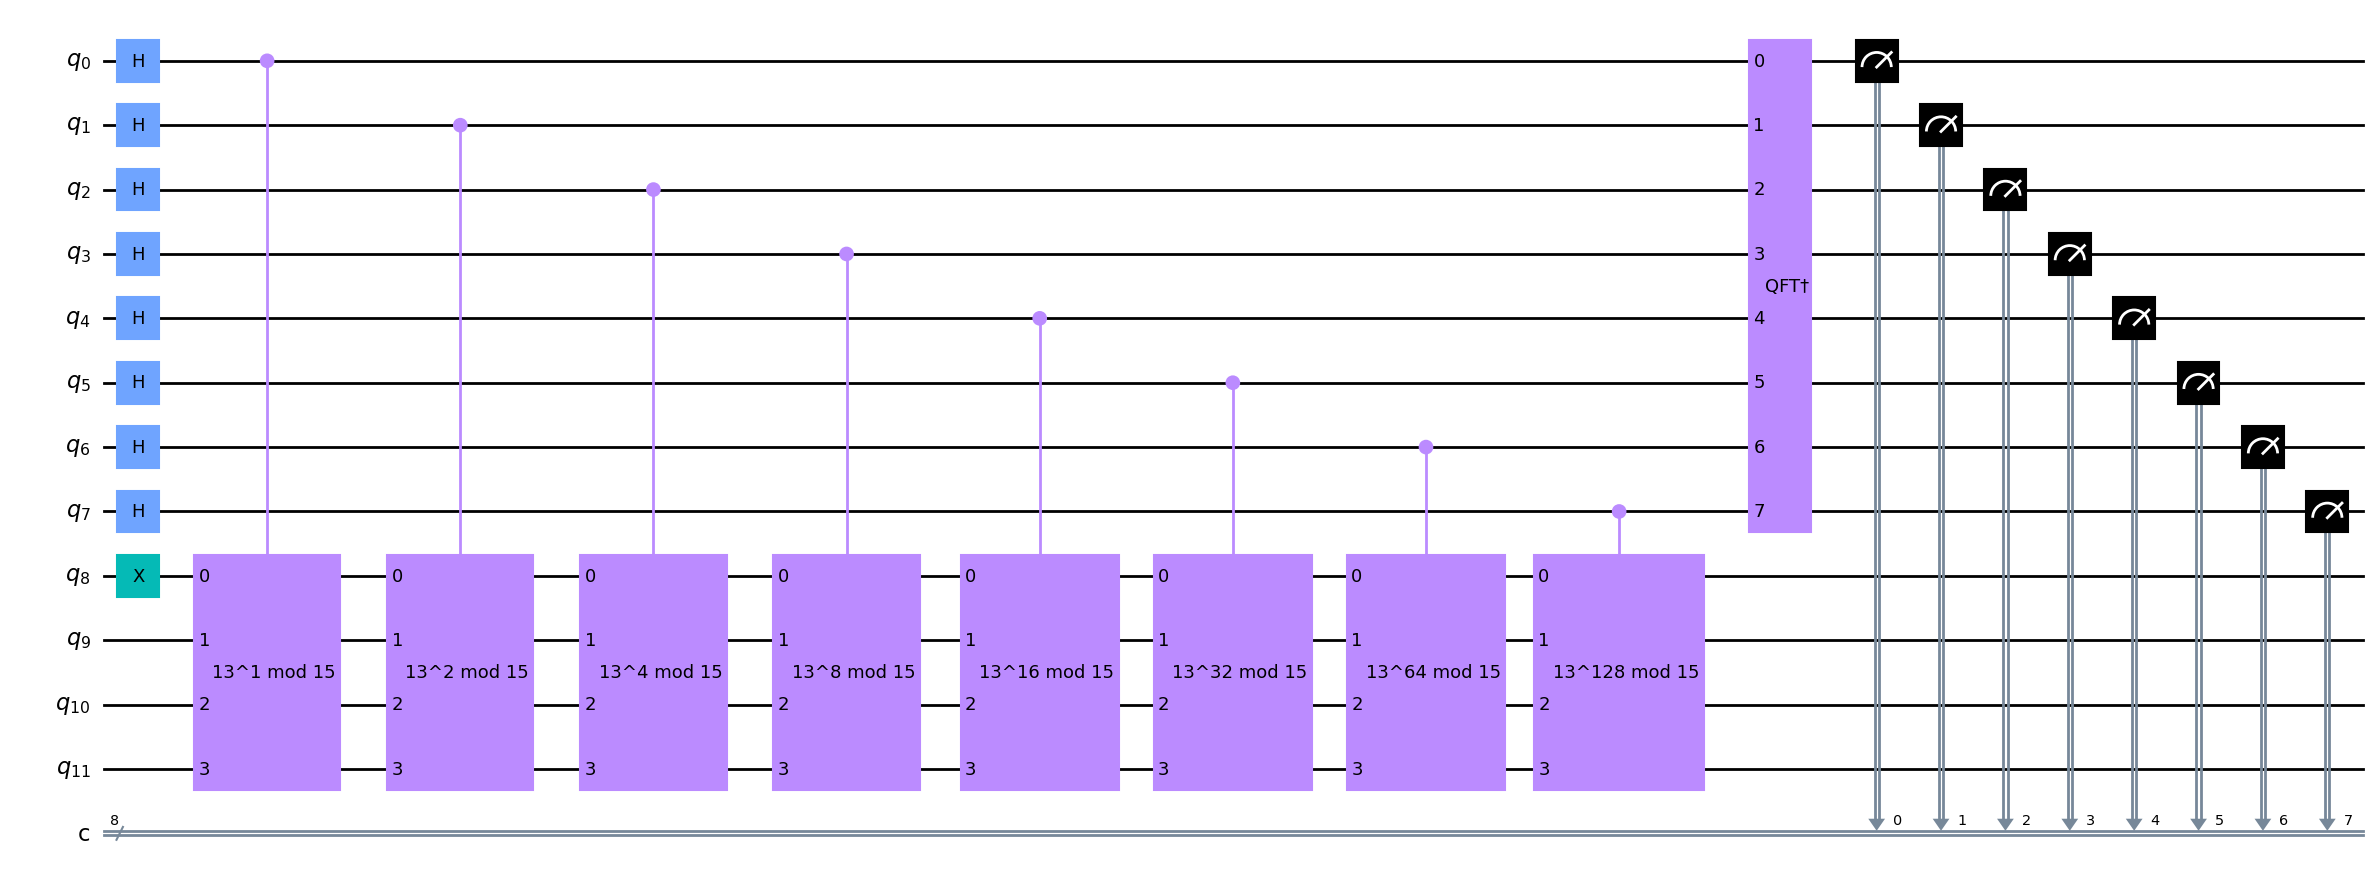

In [3]:
N_COUNT = 8
a = 13

qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw("mpl", fold=-1)  # -1 means 'do not fold'


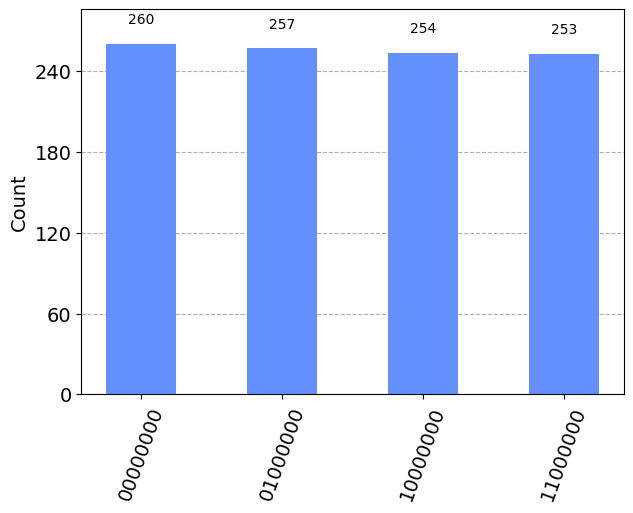

In [4]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = execute(t_qc, aer_sim).result().get_counts()
# counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [5]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  01000000(bin) =  64(dec)   64/256 = 0.25
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  00000000(bin) =   0(dec)    0/256 = 0.00
3  10000000(bin) = 128(dec)  128/256 = 0.50


In [6]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)


   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.75      3/4            4
2   0.00      0/1            1
3   0.50      1/2            2


Transpailing the circuit:

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import FakeAuckland #need to change to "
# from qiskit_ibm_runtime.fake_provider import FakeAuckland #" after qiskit 0.46
 
backend = FakeAuckland()

tran_circute = transpile(qc, backend, optimization_level = 0)

KeyboardInterrupt: 

In [ ]:
# result = execute(tran_circute, backend=backend).result()
result = backend.run(tran_circute)
print(result)

In [ ]:
res = result.result()

In [ ]:
plot_histogram(result.get_counts())

In [ ]:
tran_circute.draw(fold=-1)

In [ ]:

qc.draw(fold=-1, with_layout=False)

In [ ]:
from qiskit.tools.visualization import circuit_drawer
# tran_circute.draw( filename="shor_circuit.png")
circuit_drawer(tran_circute, output='mpl')

In [ ]:
counts = aer_sim.run(tran_circute).result().get_counts()
plot_histogram(counts)

In [ ]:
print(f"depth original circuit {qc.depth()}")
print(f"depth after transpiling {tran_circute.depth()}")

In [ ]:
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.providers.fake_provider import FakeAuckland #need to change to "from qiskit_ibm_runtime.fake_provider import FakeExample" after qiskit 0.46

fake_backend = FakeAuckland()

circ_no_bar = RemoveBarriers()(qc)

tran0 = transpile(circ_no_bar, backend=fake_backend, optimization_level=0)
# tran3 = transpile(circ_no_bar, backend=fake_backend, optimization_level=3)

result_basic = execute(circ_no_bar, backend=aer_sim).result()
# result_basic_fake = execute(circ_no_bar, backend=fake_backend).result()
# result_0 = execute(tran0, backend=fake_backend).result()
# result_3 = execute(tran3, backend=fake_backend).result()

# plot_histogram([result_basic.get_counts(), result_basic_fake.get_counts(), result_0.get_counts(), result_3.get_counts()], legend=['basic', "basic_fake", "level=0", "level=3"])


In [ ]:
result_basic_fake = execute(circ_no_bar, backend=fake_backend).result()



In [ ]:
result_0 = execute(tran0, backend=fake_backend).result()

In [ ]:
result_3 = execute(tran3, backend=fake_backend).result()

In [ ]:
depth_basic = circ_no_bar.depth()
depth0 = tran0.depth()
depth3 = tran3.depth()

plot_histogram({"basic":depth_basic, "level=0":depth0, "level=3":depth3})